In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

## Define some funtions

In [3]:
# 활성화 함수들
sig = torch.nn.Sigmoid()
soft = torch.nn.Softmax(dim=1)
tanh = torch.nn.Tanh()

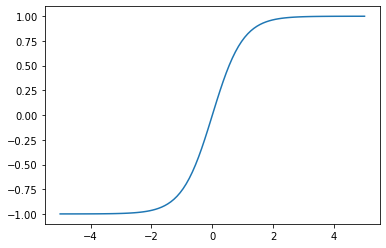

In [6]:
_x = torch.linspace(-5,5,100)
plt.plot(_x,tanh(_x))

`-` 문자열 -> 숫자로 바꾸는 함수

In [7]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 

(사용예시1)

In [8]:
txt = ['a','b','a']
mapping = {'a':33,'b':-22}
print('변환전: %s'% txt)
print('변환후: %s'% f(txt,mapping))

변환전: ['a', 'b', 'a']
변환후: [33, -22, 33]


(사용예시2) - 원핫인코딩 version

In [9]:
txt = ['a','b','a']
mapping = {'a':[1,0],'b':[0,1]}
print('변환전: %s'% txt)
print('변환후: %s'% f(txt,mapping))

변환전: ['a', 'b', 'a']
변환후: [[1, 0], [0, 1], [1, 0]]


## Exam1: ab

### data

In [10]:
txt = list('ab')*100
txt[:10]

['a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b']

In [20]:
txt_x = txt[:-1] # 처음부터 마지막 하나 빼고
txt_y = txt[1:] # 처음빼고 마지막까지

### 선형모형을 이용한 풀이

#### ***(풀이1) 1개의 파라메터 - 실패***

`-` 데이터정리 

In [22]:
x = torch.tensor(f(txt_x,{'a':0,'b':1})).float().reshape(-1,1)
y = torch.tensor(f(txt_y,{'a':0,'b':1})).float().reshape(-1,1)

`-` 학습 및 결과 시각화

In [24]:
net = torch.nn.Linear(1,1,bias=False)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

In [25]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

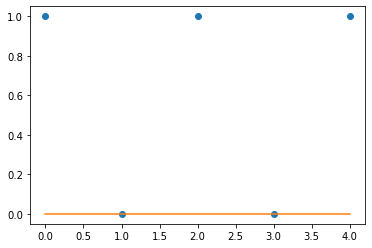

In [26]:
plt.plot(y[:5],'o')
plt.plot(net(x).data[:5])

`-` 학습이 잘 안된 이유?

In [27]:
pd.DataFrame({'x':x[:5].reshape(-1),'y':y[:5].reshape(-1)})

,x,y
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0


현재 $\hat{y}_i = \hat{w}x_i$ 꼴의 아키텍처이고 $y_i \approx \hat{w}x_i$ 가 되는 적당한 $\hat{w}$를 찾아야 하는 상황 
- $(x_i,y_i)=(0,1)$ 이면 어떠한 $\hat{w}$를 선택해도 $y_i \approx \hat{w}x_i$를 만드는 것이 불가능  
- $(x_i,y_i)=(1,0)$ 이면 $\hat{w}=0$일 경우 $y_i \approx \hat{w}x_i$로 만드는 것이 가능 

상황을 종합해보니 $\hat{w}=0$으로 학습되는 것이 그나마 최선 
- 그래서 y=0의 직선이 나온 것

#### ***(풀이2) 1개의 파라메터 - 성공, but 확장성 없는 풀이***

`-` 0이라는 값이 문제가 되므로 인코딩방식의 변경

In [28]:
x = torch.tensor(f(txt_x,{'a':-1,'b':1})).float().reshape(-1,1) 
y = torch.tensor(f(txt_y,{'a':-1,'b':1})).float().reshape(-1,1)

In [29]:
net = torch.nn.Linear(1,1,bias=False)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

In [30]:
for epoc in range(2000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

`-` 결과는 성공

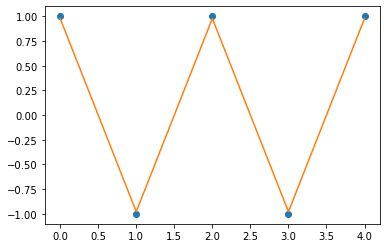

In [31]:
plt.plot(y[:5],'o')
plt.plot(net(x).data[:5])

- 딱봐도 클래스가 3개일 경우 확장이 어려워 보인다. 

### 로지스틱 모형을 이용한 풀이

#### ***(풀이1) 1개의 파라메터 -- 실패***

`-` 데이터를 다시 a=0, b=1로 정리
  - 선형모형에 적합시키기 위해서 a=-1, b=1로 정리했었음

In [34]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

In [35]:
x[:5],y[:5]

(tensor([[0.],
         [1.],
         [0.],
         [1.],
         [0.]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]]))

`-` 학습

In [36]:
net = torch.nn.Linear(1,1,bias=False)
loss_fn = torch.nn.BCEWithLogitsLoss() # 로지스틱 모형을 이용한 풀이
optimizr = torch.optim.Adam(net.parameters())

In [37]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

`-` 결과

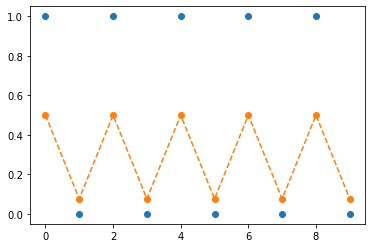

In [38]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')
# 여기서 sig를 태운 게..loss_fn을 BCEWithLogitsLoss써서 그런가? -> ㅇㅇ 아마 맞을 듯..
# loss_fn과 활성화함수의 조합에 대해서 한 번 더 생각해보자..

`-` 결과해석: 예상되었던 실패임 
- 아키텍처는 $\hat{y}_i = \text{sig}(\hat{w}x_i)$ 꼴이다. 
- $(x_i,y_i)=(0,1)$ 이라면 어떠한 $\hat{w}$을 선택해도 $\hat{w}x_i=0$ 이다. 이경우 $\hat{y}_i = \text{sig}(0) = 0.5$ 가 된다. 
- $(x_i,y_i)=(1,0)$ 이라면 $\hat{w}=-5$와 같은 값으로 선택하면 $\text{sig}(-5) \approx 0 = y_i$ 와 같이 만들 수 있다. 
- 상황을 종합하면 net의 weight는 $\text{sig}(\hat{w}x_i) \approx 0$ 이 되도록 적당한 음수로 학습되는 것이 최선임을 알 수 있다. 

In [39]:
net.weight # 적당한 음수값으로 학습되어있음을 확인

Parameter containing:
tensor([[-2.4956]], requires_grad=True)

#### ***(풀이2) 2개의 파라메터 + 좋은 초기값 -- 성공***

`-` 동일하게 a=0, b=1로 맵핑

In [40]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

`-` 네트워크에서 bias를 넣기로 결정함 

In [41]:
net = torch.nn.Linear(1,1,bias=True)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())

`-` net의 초기값을 설정 (이것은 좋은 초기값임)

In [42]:
net.weight.data = torch.tensor([[-5.00]])
net.bias.data = torch.tensor([+2.500])

`-` 학습전 결과

In [48]:
import numpy as np
1/(1+np.exp(-2.5)),1/(1+np.exp(2.5)) # x가 0일 때와 1일 때

(0.9241418199787566, 0.07585818002124355)

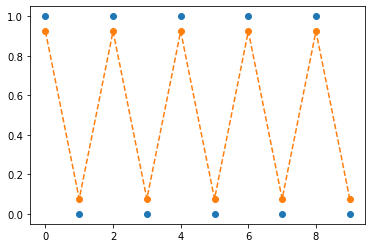

In [49]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

`-` 학습후결과

In [50]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

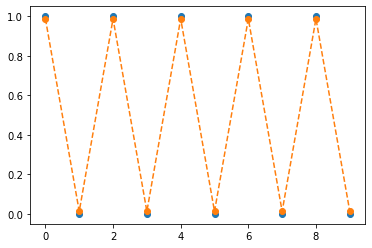

In [51]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

#### ***(풀이3) 2개의 파라메터 + 나쁜초기값 -- 성공***

`-` a=0, b=1 

In [52]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

`-` 이전과 동일하게 바이어스가 포함된 네트워크 설정 

In [53]:
net = torch.nn.Linear(1,1,bias=True)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())

`-` 초기값설정 (이 초기값은 나쁜 초기값임)

In [54]:
net.weight.data = torch.tensor([[+5.00]])
net.bias.data = torch.tensor([-2.500])

In [55]:
net(x)[:10]

tensor([[-2.5000],
        [ 2.5000],
        [-2.5000],
        [ 2.5000],
        [-2.5000],
        [ 2.5000],
        [-2.5000],
        [ 2.5000],
        [-2.5000],
        [ 2.5000]], grad_fn=<SliceBackward0>)

`-` 학습전상태: 반대모양으로 되어있다. 

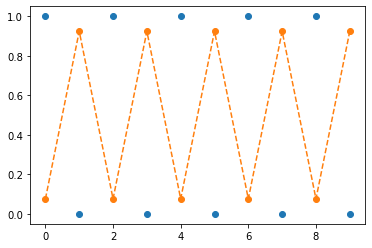

In [56]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

`-` 학습

In [59]:
for epoc in range(50000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

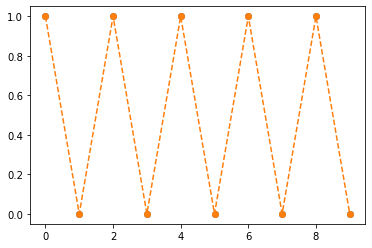

In [60]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

- loop을 상당히 돌리긴 했지만 수렴하긴 함

#### ***(풀이4) 3개의 파라메터를 쓴다면?***

`-` a=0, b=1로 코딩 

In [61]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

`-` 3개의 파라메터를 사용하기 위해서 아래와 같은 구조를 생각하자. 

```Python
torch.nn.Sequential(
    torch.nn.Linear(1,1,bias=True), # 2개의 파라미터
    torch.nn.ACTIVATION_FUNCTION(), # 활성화 함수
    torch.nn.Linear(1,1,bias=False) # 1개의 파라미터
)
````

- 위와 같은 네트워크를 설정하면 3개의 파라메터를 사용할 수 있다.
- 적절한 ACTIVATION_FUNCTION을 골라야 하는데 실험적으로 tanh가 적절하다고 알려져있다 $\to$ 그래서 우리도 실험적으로 이해해보자

--- 

(예비학습1) 
- 사실 net.forward(x)와 net(x)는 같다. 

In [63]:
net(x)[:5] # 풀이3에서 학습한 네트워크임

tensor([[ 15.5369],
        [-15.8519],
        [ 15.5369],
        [-15.8519],
        [ 15.5369]], grad_fn=<SliceBackward0>)

In [64]:
net.forward(x)[:5] # 풀이3에서 학습한 네트워크임

tensor([[ 15.5369],
        [-15.8519],
        [ 15.5369],
        [-15.8519],
        [ 15.5369]], grad_fn=<SliceBackward0>)

- 그래서 net.forward를 재정의하면 net(x)의 기능을 재정의 할 수 있다. 

In [65]:
net.forward = lambda x: 1 

- "net.forward = lambda x:1" 이라고 새롭게 선언하였므로 앞으론 net.forward(x), net(x) 도 입력값에 상관없이 항상 1을 출력하게 될 것임 

In [66]:
net(x)

1

(예비학습2) 

(예시1) - 활성화함수 : sigmoid

In [67]:
class Mynet1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(1,1,bias=True)
        self.a1 = torch.nn.Sigmoid()
        self.l2 = torch.nn.Linear(1,1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

(예시2) - 활성화함수 : ReLU

In [68]:
class Mynet2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(1,1,bias=True)
        self.a1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(1,1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

(예시3) - 활성화함수 : Tanh

In [69]:
class Mynet3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(1,1,bias=True)
        self.a1 = torch.nn.Tanh()
        self.l2 = torch.nn.Linear(1,1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

--- 

> ### 활성화함수로서 tanh가 왜 적절한지 직관을 얻어보자. 

`-` 실험결과1(Sig): Sigmoid activation을 포함한 아키텍처로 학습시킨 25개의 적합결과

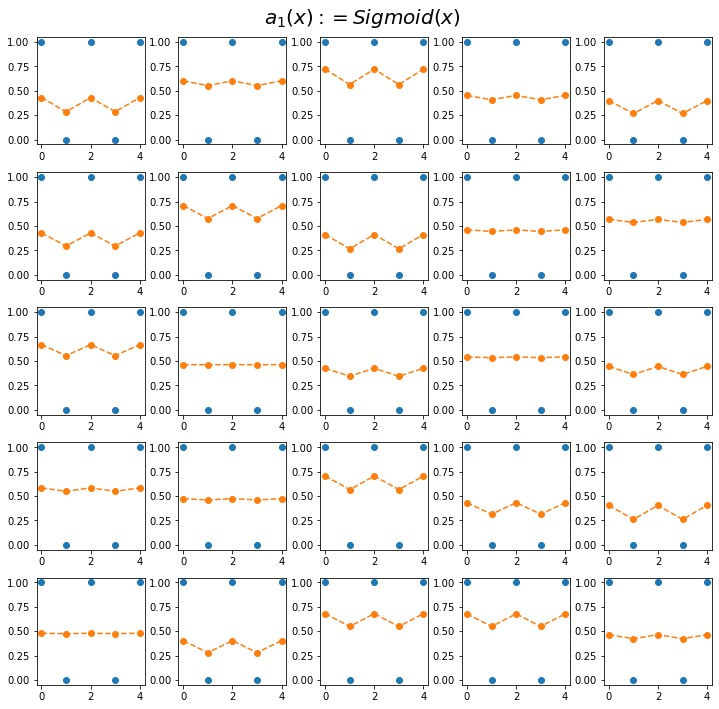

In [70]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Mynet1()
        loss_fn = torch.nn.BCEWithLogitsLoss()
        optimizr = torch.optim.Adam(net.parameters())
        for epoc in range(1000):
            loss = loss_fn(net(x),y)
            loss.backward()
            optimizr.step()
            optimizr.zero_grad()
        ax[i][j].plot(y[:5],'o')
        ax[i][j].plot(sig(net(x[:5])).data,'--o')
fig.suptitle(r"$a_1(x):=Sigmoid(x)$",size=20)
fig.tight_layout()

`-` 실험결과2(ReLU): ReLU activation을 포함한 아키텍처로 학습시킨 25개의 적합결과

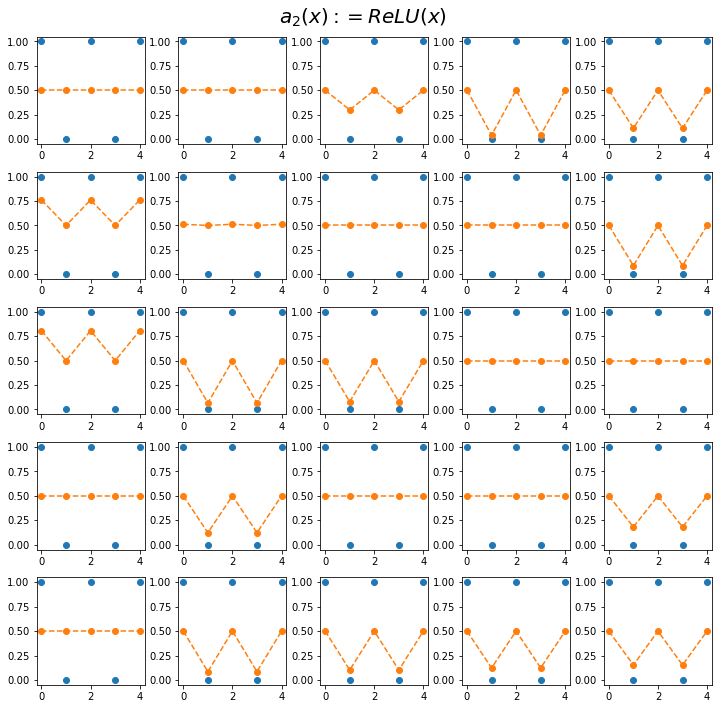

In [71]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Mynet2()
        loss_fn = torch.nn.BCEWithLogitsLoss()
        optimizr = torch.optim.Adam(net.parameters())
        for epoc in range(1000):
            loss = loss_fn(net(x),y)
            loss.backward()
            optimizr.step()
            optimizr.zero_grad()
        ax[i][j].plot(y[:5],'o')
        ax[i][j].plot(sig(net(x[:5])).data,'--o')
fig.suptitle(r"$a_2(x):=ReLU(x)$",size=20)
fig.tight_layout()

`-` 실험결과3(Tanh): Tanh activation을 포함한 아키텍처로 학습시킨 25개의 적합결과

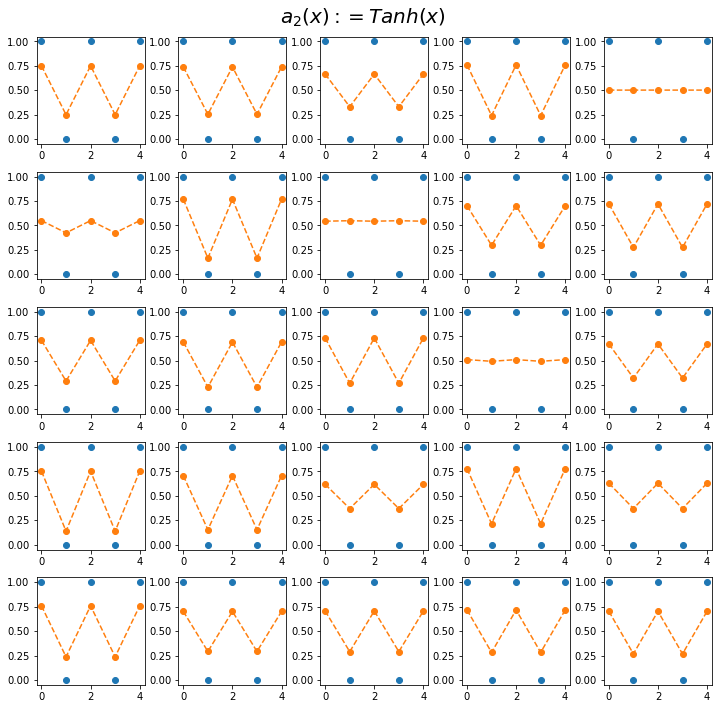

In [72]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Mynet3()
        loss_fn = torch.nn.BCEWithLogitsLoss()
        optimizr = torch.optim.Adam(net.parameters())
        for epoc in range(1000):
            loss = loss_fn(net(x),y)
            loss.backward()
            optimizr.step()
            optimizr.zero_grad()
        ax[i][j].plot(y[:5],'o')
        ax[i][j].plot(sig(net(x[:5])).data,'--o')
fig.suptitle(r"$a_2(x):=Tanh(x)$",size=20)        
fig.tight_layout()

`-` 실험해석
- sig: 주황색선의 변동폭이 작음 + 항상 0.5근처로 머무는 적합값이 존재 
- relu: 주황색선의 변동폭이 큼 + 항상 0.5근처로 머무는 적합값이 존재 
- tanh: 주황색선의 변동폭이 큼 + 0.5근처로 머무는 적합값이 존재X

`-` 실험해보니까 tanh가 우수한것 같다. $\to$ 앞으로는 tanh를 쓰자. 

### 소프트맥스로 확장

#### (풀이1) 로지스틱모형에서 3개의 파라메터 버전을 그대로 확장 

In [73]:
mapping = {'a':[1,0],'b':[0,1]} # 소프트 맥스로 확장하기 위해서..
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,2)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,2)

In [74]:
net = torch.nn.Sequential(
    torch.nn.Linear(2,1), # 입력이 원핫 인코딩 형태임..
    torch.nn.Tanh(),
    torch.nn.Linear(1,2,bias=False)
)
loss_fn = torch.nn.CrossEntropyLoss() # 소프트 맥스로 확장하기 위해서..
optimizr = torch.optim.Adam(net.parameters())

In [75]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

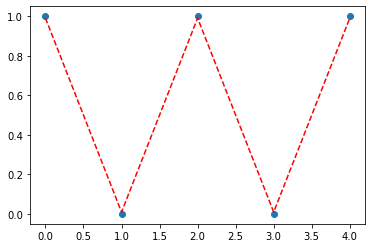

In [76]:
plt.plot(y[:5][:,1],'o')
plt.plot(soft(net(x[:5]))[:,1].data,'--r')

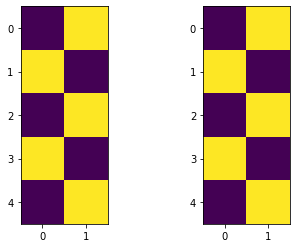

In [77]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(y[:5])
ax[1].imshow(soft(net(x[:5])).data)

## Embedding Layer

`-` 결국 최종적으로는 아래와 같은 맵핑방식이 확장성이 있어보인다. 

In [78]:
mapping = {'a':[1,0,0],'b':[0,1,0],'c':[0,0,1]} # 원핫인코딩 방식 

`-` 그런데 매번 $X$를 원핫인코딩하고 Linear 변환하는것이 번거로운데 이를 한번에 구현하는 함수가 있으면 좋겠다
  - $\to$ torch.nn.Embedding Layer가 그 역할을 한다. 

In [82]:
mapping = {'a':0,'b':1,'c':2}
x = torch.tensor(f(list('abc')*100,mapping))
y = torch.tensor(f(list('bca')*100,mapping))
x[:5],y[:5]

(tensor([0, 1, 2, 0, 1]), tensor([1, 2, 0, 1, 2]))

In [83]:
torch.manual_seed(43052)
ebdd = torch.nn.Embedding(num_embeddings=3,embedding_dim=1)

In [84]:
ebdd(x)[:5]

tensor([[-0.8178],
        [-0.7052],
        [-0.5843],
        [-0.8178],
        [-0.7052]], grad_fn=<SliceBackward0>)

`-` 그런데 사실 언뜻보면 아래의 linr 함수와 역할의 차이가 없어보인다. 

In [87]:
torch.manual_seed(43052)
linr = torch.nn.Linear(1,1)

In [88]:
linr(x.float().reshape(-1,1))[:5]

tensor([[-0.8470],
        [-1.1937],
        [-1.5404],
        [-0.8470],
        [-1.1937]], grad_fn=<SliceBackward0>)

`-` 차이점: 파라메터수에 차이가 있다. 

In [89]:
ebdd.weight

Parameter containing:
tensor([[-0.8178],
        [-0.7052],
        [-0.5843]], requires_grad=True)

In [90]:
linr.weight, linr.bias

(Parameter containing:
 tensor([[-0.3467]], requires_grad=True),
 Parameter containing:
 tensor([-0.8470], requires_grad=True))

결국 ebdd는 아래의 구조에 해당하는 파라메터들이고 

- $\text{x[:5]}= \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \Longrightarrow \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix} \quad net(x)= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \end{bmatrix} = \begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \\ -0.8178 \\ -0.7052  \end{bmatrix} $

linr는 아래의 구조에 해당하는 파라메터이다. 

- $\text{x[:5]}= \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \quad net(x)=  \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \times (-0.3467) + (-0.8470)=\begin{bmatrix} -0.8470 \\ -1.1937 \\ -1.5404 \\ -0.8470 \\ -1.1937 \end{bmatrix}$

### 연습 (ab문제 소프트맥스로 확장한 것 다시 풀이)

`-` 맵핑

In [91]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))

`-` torch.nn.Embedding 을 넣은 네트워크 

In [92]:
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=2,embedding_dim=1),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1,out_features=2)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

`-` 학습

In [93]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

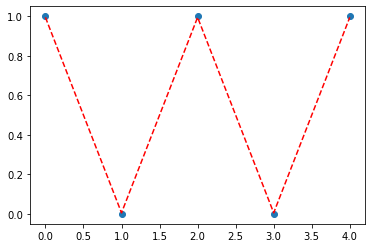

In [94]:
plt.plot(y[:5],'o')
plt.plot(soft(net(x[:5]))[:,1].data,'--r')

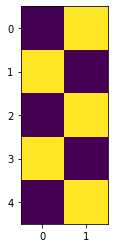

In [95]:
plt.imshow(soft(net(x[:5])).data)

---

## HW

아래의 코드를 관찰하라. 

In [36]:
x = [0,1]*5
y = [1,0]*5
ebdd = torch.nn.Embedding(num_embeddings=2,embedding_dim=1)

In [37]:
ebdd.weight

Parameter containing:
tensor([[2.1010],
        [0.9350]], requires_grad=True)

ebdd(x)의 출력결과를 예측하여 작성하라. 

$ \begin{bmatrix} 2.1010 \\ 0.9350 \\ 2.1010 \\ 0.9350 \\ 2.1010 \\ 0.9350\\2.1010 \\ 0.9350\\2.1010 \\ 0.9350  \end{bmatrix} $